In [1]:
%%capture
%pip install -r requirements.txt

In [2]:
import pyvista as pv
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import logging
import pint
from scipy.constants import mu_0 as _mu_0
from scipy.special import iv, jv # Modified Bessel function of the first kind

Q = pint.UnitRegistry()
Q.setup_matplotlib()

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
pv.set_jupyter_backend('static') 

In [3]:
_mu_0

1.25663706212e-06

In [4]:
RESOLUTION=100


In [5]:
diameter = 4e-3 * Q.meter
conductivity = 37e6 * Q.siemens / Q.meter
resistivity = 1 / conductivity
frequency = 200e3 * Q.Hz

resistance = 1 / (conductivity * np.pi * diameter**2 / 4)
resistance.to(Q.ohm/Q.meter)

omega = (frequency * 2 * np.pi).to(Q.rad/Q.second)

MU_0 = _mu_0 * Q.henry / Q.meter
mu_r = 1
mu = mu_r * MU_0



In [6]:
vtu_files = [f  for f in os.listdir(os.path.join(os.curdir,'results')) if f.endswith('.vtu')]
vtu_files.sort()
print(f'{len(vtu_files)} vtu files found')

101 vtu files found


In [7]:
dt = 1 / frequency / len(vtu_files)
print(f'Time step: {dt.to(Q.microsecond)}')

Time step: 0.04950495049504951 microsecond


In [8]:
mesh_t0 = pv.read(os.path.join(os.curdir,'results', vtu_files[20]))

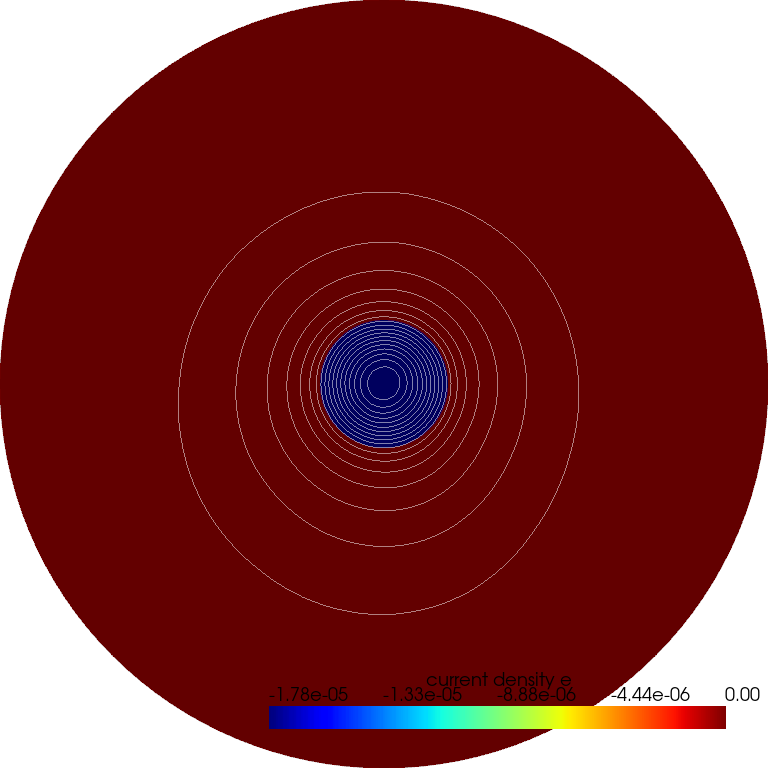

In [9]:
p = pv.Plotter(notebook=True)
p.add_mesh(mesh_t0, scalars="current density e", component=2, show_edges=False, cmap='jet')
p.add_mesh(mesh_t0.contour(isosurfaces=20, scalars='a', method='contour'),color='white',point_size=1, show_edges=False, opacity=0.5)
p.set_viewup([0,1,0])
p.camera.zoom('tight')
p.show()

In [10]:
WIRE_1_ID = 1
WIRE_2_ID = 2

wire_1 = mesh_t0.threshold([WIRE_1_ID - 0.1, WIRE_1_ID + 0.1], scalars="GeometryIds")

In [11]:
diameter.to_base_units().m

0.004

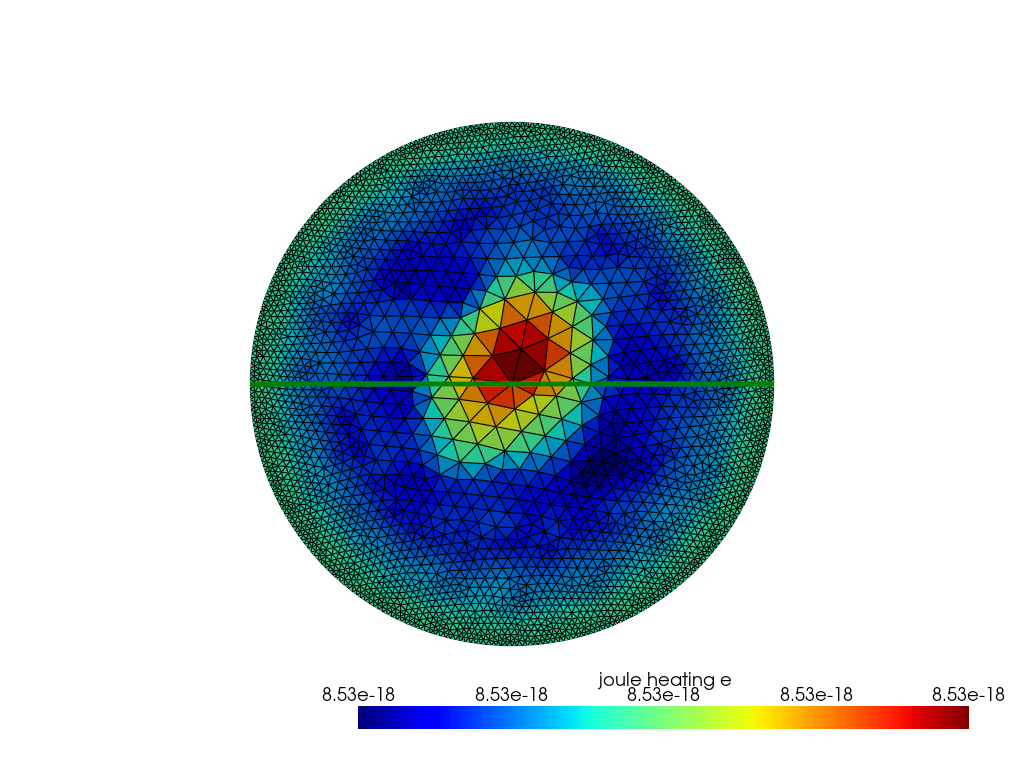

In [12]:
p = pv.Plotter(shape=(1, 1))
p.subplot(0, 0)
p.add_mesh(wire_1, scalars="joule heating e", component=2, show_edges=True, cmap='jet')
#p.update_scalar_bar_range([-200e3, 0])
p.set_viewup([0, 1, 0])
p.add_mesh(pv.Line((-diameter.to_base_units().m/2, 0, 0), (diameter.to_base_units().m/2, 0, 0)), color='green', line_width=5)

# p.subplot(0, 1)

# p.add_mesh(wire_1, scalars="joule heating e", show_edges=True, cmap='jet')
# p.set_viewup([0,1,0])
p.show()

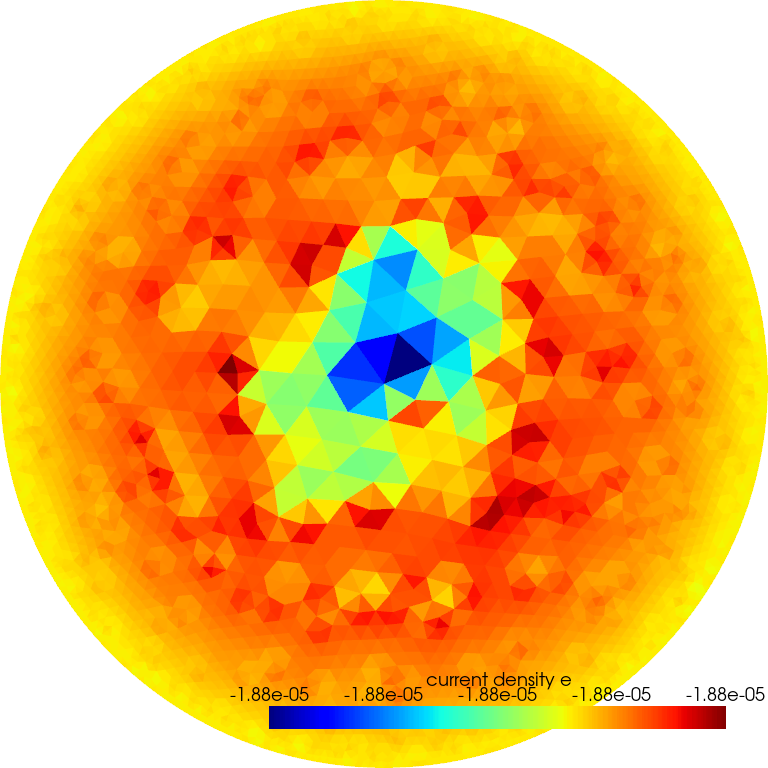

/Users/martinwest/Repositories/elmer-elmag/.venv/lib/python3.12/site-packages/pint/facets/numpy/numpy_func.py:322: RuntimeWarning: invalid value encountered in multiply
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/Users/martinwest/Repositories/elmer-elmag/.venv/lib/python3.12/site-packages/pyvista/plotting/plotter.py:4872: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the points of a mesh in-place instead.
  warnings.warn(
/Users/martinwest/Repositories/elmer-elmag/.venv/lib/python3.12/site-packages/pyvista/plotting/plotter.py:4796: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the scalars of a mesh in-place instead.
  warnings.warn(


In [13]:


p = pv.Plotter(notebook=True, off_screen=True)
p.open_gif('results/j.gif')

mesh = pv.read(os.path.join(os.curdir,'results', vtu_files[0]))
wire_mesh = mesh.threshold([WIRE_1_ID - 0.1, WIRE_1_ID + 0.1], scalars="GeometryIds")
p.add_mesh(wire_mesh, scalars="current density e", component=2, show_edges=False, cmap='jet', lighting=False)
p.set_viewup([0,1,0])
p.camera.zoom('tight')
p.show()
p.update_scalar_bar_range([-7e6, 7e6])

wire_currrent = np.empty((len(vtu_files), 2)) * Q.A
wire_joule_heating = np.empty((len(vtu_files), 2)) * Q.W / Q.m
wire_current_density = np.empty((len(vtu_files), RESOLUTION+1)) * Q.A / Q.m**2
wire_positions = np.linspace(-diameter/2, diameter/2, RESOLUTION+1)

for idx, vtu_file in enumerate(vtu_files):
    mesh = pv.read(os.path.join(os.curdir,'results', vtu_file))
    for wire in [WIRE_1_ID, WIRE_2_ID]:
        wire_mesh = mesh.threshold([wire - 0.1, wire + 0.1], scalars="GeometryIds")
        wire_mesh_int = wire_mesh.integrate_data()
        wire_currrent[idx, wire - 1] = wire_mesh_int['current density e'][0, 2] * Q.A # 2 is the z component
        wire_joule_heating[idx, wire - 1] = wire_mesh_int['joule heating e'][0] * Q.W / Q.m
        # sample across the wire,
        if wire == WIRE_1_ID:
            p.update_coordinates(wire_mesh.points, render=False)
            p.update_scalars(wire_mesh['current density e'][:,2], render=False)
            p.write_frame()
            line_sample = wire_mesh.sample_over_line((-diameter.to_base_units().m/2,0,0),
                                                     ( diameter.to_base_units().m/2,0,0), resolution=RESOLUTION)
            wire_current_density[idx] = line_sample['current density e'][:,2] * Q.A / Q.m**2
p.close()

In [14]:
delta = np.sqrt((2 * resistivity)/((2*np.pi*frequency).to(Q.rad/Q.s) * mu))
delta.to(Q.mm)

<Quantity(0.185013863, 'millimeter')>

In [15]:
mu / (4e-7 *np.pi)

<Quantity(1.0, 'henry / meter')>

In [16]:
 
def J(r, i, diameter, resistivity, frequency, mu):
    omega = (frequency * 2 * np.pi).to(Q.rad/Q.s)
    delta = np.sqrt((2 * resistivity)/(omega * mu))
    delta.ito(Q.m)
    diameter.ito(Q.m)
    i.ito(Q.A)
    r.ito(Q.m)
    k = (1 - 1j) / delta.m
    j_r = ((k * i.m)/(2 * np.pi * (diameter/2).m)) * (jv(0, (k*r).m) / jv(1, (k*(diameter/2)).m))
    return j_r

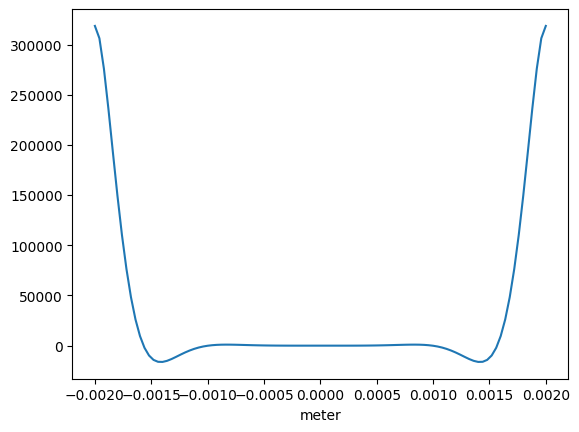

In [17]:
j = J(wire_positions, 1/np.sqrt(2) * Q.A, diameter, resistivity, frequency, mu)

plt.plot(wire_positions, j.real, label='Real')



In [18]:
1/np.sqrt(2) * Q.A / (np.pi * (diameter/2)**2).to(Q.m**2)

<Quantity(56269.7698, 'ampere / meter ** 2')>

In [19]:
r = (1 + 1j) * diameter.to(Q.m) / delta
f_skin = 0.5 * (r.to_base_units().magnitude * iv(0, r.to_base_units().magnitude) / iv(1, r.to_base_units().magnitude)).real

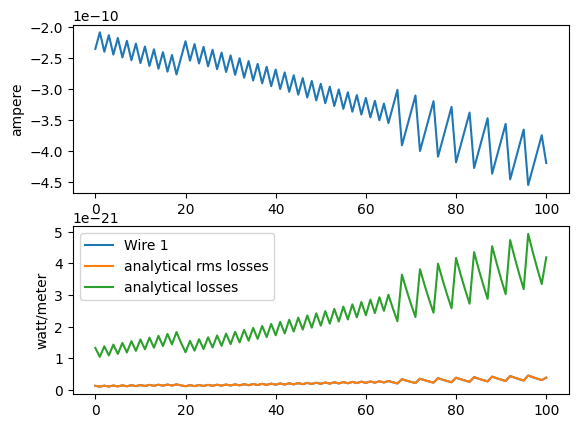

In [20]:

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(wire_currrent[:,0], label='Wire 1')

ax2 = fig.add_subplot(212)
ax2.plot(wire_joule_heating[:,0], label='Wire 1')
ax2.plot(wire_currrent[:,0]**2 * resistance , label='analytical rms losses')
ax2.plot(wire_currrent[:,0]**2 * resistance * f_skin, label='analytical losses')
ax2.legend()

In [21]:
f_skin

np.float64(11.064330415488033)

In [22]:
np.sqrt(np.mean(wire_current_density**2, axis=0))

Magnitude,[0.0 2.530317533550657e-05 2.530281970377161e-05 2.5302636467111646e-05 2.5302479782532974e-05 2.5302129677684243e-05 2.530193714825082e-05 2.5301566135396088e-05 2.5301189144807846e-05 2.5301189144807846e-05 2.5300725309929818e-05 2.5300447351026413e-05 2.5300117221373208e-05 2.5300117221373208e-05 2.5299493026830587e-05 2.529941155317034e-05 2.5298679817563748e-05 2.5298679817563748e-05 2.529827084782723e-05 2.5297916764453446e-05 2.5297916764453446e-05 2.5297542207971377e-05 2.5297208053694253e-05 2.5297208053694253e-05 2.5296851711574504e-05 2.5296531822232086e-05 2.5296531822232086e-05 2.5296228853526383e-05 2.5295937690550414e-05 2.5295937690550414e-05 2.5295699406111166e-05 2.5295453095316865e-05 2.5295453095316865e-05 2.5295338282017118e-05 2.5295338282017118e-05 2.529505545091651e-05 2.529505545091651e-05 2.529488250115918e-05 2.529488250115918e-05 2.5294665831591592e-05 2.5294665831591592e-05 2.5294665831591592e-05 2.5294571136558016e-05 2.5294571136558016e-05 2.5294476395697697e-05 2.5294476395697697e-05 2.5294476395697697e-05 2.5294476395697697e-05 2.5294476395697697e-05 2.5294476395697697e-05 2.5294476395697697e-05 2.5294479344510362e-05 2.5294479344510362e-05 2.5294479344510362e-05 2.5294479344510362e-05 2.5294479344510362e-05 2.5294567074135295e-05 2.5294567074135295e-05 2.529471348472054e-05 2.529471348472054e-05 2.529471348472054e-05 2.529489796851735e-05 2.5295071342237264e-05 2.5295071342237264e-05 2.5295071342237264e-05 2.5295071342237264e-05 2.5295499878365247e-05 2.5295499878365247e-05 2.5295499878365247e-05 2.5295774053869244e-05 2.529599460338082e-05 2.529599460338082e-05 2.5296288094106696e-05 2.5296581410822827e-05 2.5296581410822827e-05 2.5296921327318385e-05 2.5296921327318385e-05 2.529725377884402e-05 2.529725377884402e-05 2.5297949125843435e-05 2.5297949125843435e-05 2.529836766284569e-05 2.529872491603154e-05 2.529872491603154e-05 2.5299449046359093e-05 2.5299449046359093e-05 2.5300083919588663e-05 2.5300083919588663e-05 2.5300652860511578e-05 2.5300652860511578e-05 2.5301065660505997e-05 2.5301399591521768e-05 2.5301577057992066e-05 2.5301943695383262e-05 2.5302113931167637e-05 2.5302319778062492e-05 2.530268696432108e-05 2.5303065241859385e-05 2.53032068149593e-05 2.5303422700407583e-05 0.0]
Units,ampere/meter2


In [23]:
np.sqrt(np.mean(wire_current_density**2, axis=1))

Magnitude,[1.8568031706852766e-05 1.6454752632391518e-05 1.892872763914569e-05 1.6815469413147425e-05 1.9289447327206212e-05 1.7176190828862704e-05 1.9650170204562863e-05 1.7536915025037914e-05 2.001089560563137e-05 1.7897641541078445e-05 2.0371623158819538e-05 1.8258370064352504e-05 2.073235259292198e-05 1.8619100359561277e-05 2.109308370201714e-05 1.8979832242277866e-05 2.144267060253198e-05 1.9341055779653957e-05 2.1814986595991923e-05 1.9701694215442578e-05 1.758941463844919e-05 2.0062279222467652e-05 1.795007025827557e-05 2.0422951383563376e-05 1.8310752939007064e-05 2.0783642063514915e-05 1.867144996968285e-05 2.114434426329825e-05 1.9032156450739425e-05 2.1505406630511186e-05 1.939319591273304e-05 2.1866028541159755e-05 1.9753843600886845e-05 2.222695595842372e-05 2.0114763758563254e-05 2.2587905370062584e-05 2.0475701396621382e-05 2.2948572134832344e-05 2.083636390807795e-05 2.330937068095746e-05 2.1197166367716404e-05 2.3670497799724106e-05 2.1558251958396173e-05 2.4031109042567453e-05 2.191889023266282e-05 2.4391888084954433e-05 2.2279652931581318e-05 2.4752854401934388e-05 2.2640655197054008e-05 2.511350438227285e-05 2.3001285296989e-05 2.547449424403049e-05 2.3362261585310268e-05 2.583514625383382e-05 2.3722901671599826e-05 2.619592068829753e-05 2.4083750614535452e-05 2.655672161399486e-05 2.4444493727369866e-05 2.691765310720568e-05 2.4805448550691314e-05 2.727826672331879e-05 2.5166083831657727e-05 2.7647078943038367e-05 2.55520087974802e-05 2.7989086974994527e-05 2.5888124484176585e-05 2.377401564235276e-05 3.082149455923863e-05 2.872235841276657e-05 2.6610093680341263e-05 2.449564608573425e-05 3.154557880205505e-05 2.9444068264546266e-05 2.7331776664228654e-05 2.5217311261861794e-05 3.226325883486295e-05 3.016567786880289e-05 2.805340093413688e-05 2.5938949315523406e-05 3.298789395766605e-05 3.088732451028758e-05 2.8775038704502427e-05 2.6660581757924002e-05 3.3706523772835785e-05 3.160904503817426e-05 2.9496753681442316e-05 2.7382293027733524e-05 3.443818110102491e-05 3.229438899097795e-05 3.021731841735669e-05 2.810323444742954e-05 3.513337041480349e-05 3.305194275198363e-05 3.093966517541532e-05 2.8825210264823727e-05 3.587315883288936e-05 3.377129813781642e-05 3.166098211413411e-05 2.95592576995598e-05 3.307456087686298e-05]
Units,ampere/meter2


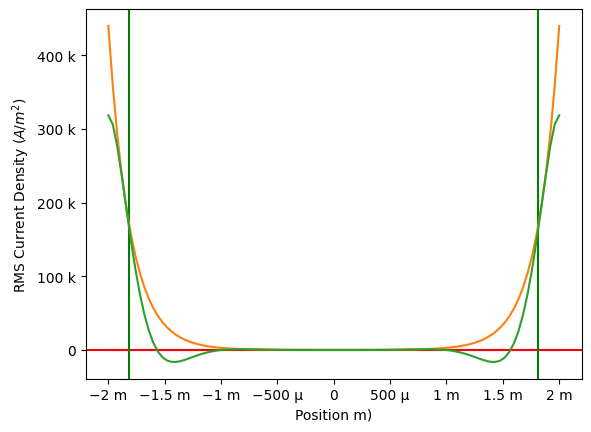

In [24]:

fig = plt.figure()
ax = fig.add_subplot(111)
#use the enginering tick formatter

ax.yaxis.set_major_formatter(EngFormatter())
ax.xaxis.set_major_formatter(EngFormatter())

ax.plot(wire_positions, np.sqrt(np.mean(wire_current_density**2, axis=1)))

ax.set_xlabel('Position m)')
ax.set_ylabel('RMS Current Density ($A/m^2$)')
rms_dc_current_density = np.sqrt(np.mean(wire_currrent**2, axis=0)) / (np.pi * (diameter/2)**2)
ax.axhline(rms_dc_current_density[0], color='red', label='Wire 1 RMS')
ax.axvline(-diameter/2+delta, color='green', label='Skin Depth')
ax.axvline(diameter/2-delta, color='green', label='Skin Depth')
ax.plot(wire_positions, np.abs(j), label='Analytical')
ax.plot(wire_positions, j.real, label='Analytical')


In [25]:
rms_dc_current_density

Magnitude,[2.5297561129316293e-05 0.0]
Units,ampere/meter2
